<a href="https://colab.research.google.com/github/mloyorev/Theory/blob/main/HighPerformanceComputing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will ***need the following imports***...

In [1]:
!pip install quantecon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 4.7 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

# ***1. Numba***

***Numba*** is a python library that ***solves*** many of the ***problems of algorithm performance*** through something called ***JIT (Just In Time) compilation***.

The key idea of JIT compilation is to compile functions to native machine code instructions on the fly.

By ***compiling*** we mean the process of ***translating*** source code written in the Python programming language ***into lower-level code*** that the computer can understand and execute directly.

In general terms, Numba library is specifically designed for numerical work.



Let's consider the equation...

$$x_{t+1}=αx_t(1-x_t)$$

where $α=4$

Here’s the plot of a typical trajectory, starting from $x_0=0.1$ with $t$ on the x-axis.

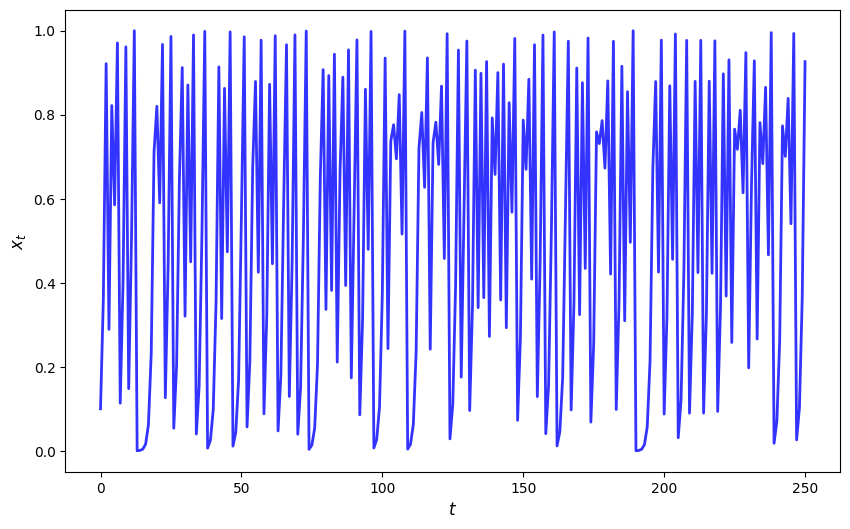

In [4]:
α = 4
def qm(x0, n):
    x    = np.empty(n+1)
    x[0] = x0
    for t in range(n):
      x[t+1] = α * x[t] * (1 - x[t])
    return x

x       = qm(0.1, 250)
fig, ax = plt.subplots()
ax.plot(x, 'b-', lw=2, alpha=0.8)
ax.set_xlabel('$t$', fontsize=12)
ax.set_ylabel('$x_{t}$', fontsize = 12)
plt.show()

To ***speed the function 'qm' up using Numba***, our first step is...

In [5]:
from numba import jit
qm_numba = jit(qm)

<ipython-input-5-7ed0cfe7e226>:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  qm_numba = jit(qm)


The function 'qm_numba' is a version of 'qm' that is “targeted” for JIT-compilation.

***Let’s time and compare identical function*** calls across these two versions, ***starting with the original function*** 'qm':

In [6]:
n = 10_000_000
qe.tic()
qm(0.1, int(n))
time1 = qe.toc()

TOC: Elapsed: 0:00:11.97


Now let’s try qm_numba...

In [7]:
qe.tic()
qm_numba(0.1, int(n))
time2 = qe.toc()

TOC: Elapsed: 0:00:0.27


The ***speed gain*** could be computed ...

In [8]:
speed_gain = time1 / time2
print(speed_gain)

42.83773914586618


This kind of speed gain is huge relative to how simple and clear the implementation is.

In the code above we created a JIT compiled version of qm via the call.

In practice this would typically be done using an ***alternative decorator syntax***.

To target a function for JIT compilation we can ***put @jit before the function*** definition.

Here’s what this looks like for 'qm'

In [9]:
@jit
def qm(x0, n):
    x    = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = α * x[t] * (1 - x[t])
    return x

<ipython-input-9-7c093ecad7fb>:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def qm(x0, n):


This is equivalent to qm = jit(qm).

The ***following now uses the jitted version***:

In [10]:
qm(0.1, 10)

array([0.1       , 0.36      , 0.9216    , 0.28901376, 0.82193923,
       0.58542054, 0.97081333, 0.11333925, 0.40197385, 0.9615635 ,
       0.14783656])

***Type inference is*** a process in which the compiler automatically determines the data types of variables and objects used in the code without the programmer explicitly specifying them. In the context of JIT compilation, ***type inference is crucial to optimizing code performance***.

Logically, type inference is easier for simple objects in Python.

For example, ***Numba works well with NumPy arrays*** and can effectively infer their types.

***When Numba can infer all the necessary types***, it can generate native machine code without having to call the Python runtime.

This is what...


1.   Significantly improves the speed of code execution
2.   This is what puts Numba-generated code on a par with low-level language-generated machine code.

***If Numba cannot infer all the types*** needed to generate native machine code, code execution falls back to the Python runtime. In these cases, ***the speed benefits of Numba may be minimal*** to none.

To detect and resolve type inference problems, it is preferable for Numba to raise an error rather than run code without optimization. To force this behavior, the ***@njit decorator is used instead of @jit***.

For example...

In [11]:
from numba import njit

@njit
def qm(x0, n):
    x    = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    return x

# ***2. Parallelization***

The growth of CPU clock speed has slowed dramatically in recent years.

Chip designers and computer programmers have responded to the slowdown by seeking a different path to fast execution: ***parallelization***.

Hardware makers have increased the number of cores (physical CPUs) embedded in each machine.

For programmers, the challenge has been to exploit these multiple CPUs by running many processes in parallel (i.e., simultaneously).

There are ***two main types*** of parallelization:

*   ***Multiprocessing:*** Concurrent execution of multiple processes using more than one processor.
*   ***Multithreading:*** Similar to multiprocessing, except that, during execution, the threads all share the same memory space.

Multithreading is more lightweight because most system and memory resources are shared by the threads.

For the great majority of what we do in these lectures, ***multithreading will suffice***.





Numba provides another approach to multithreading that will work for us almost everywhere parallelization is possible: ***multithreaded loops in numba***.

To illustrate, let’s look first at a simple, single-threaded (i.e., non-parallelized) piece of code.



Th code simulates ***updating the wealth*** $w_t$ of household via the rule...

$$w_{t+1}=R_{t+1}sw_t+y_{t+1}$$

where...

*   $R$ is the gross return on assets.
*   $s$ is the savings rate of household.
*   $y$ is the labor income of the household.

We model both
 and
 as independent draws from a lognormal distribution.

Here’s the code:







In [12]:
from numpy.random import randn
from numba import njit

@njit
def h(w, r=0.1, s=0.3, v1=0.1, v2=1.0):
    """
    Updates household wealth.
    """

    # Draw shocks
    R = np.exp(v1 * randn()) * (1 + r)
    y = np.exp(v2 * randn())

    # Update wealth
    w = R * s * w + y
    return w

Let’s have a look at ***how wealth evolves*** under this rule.

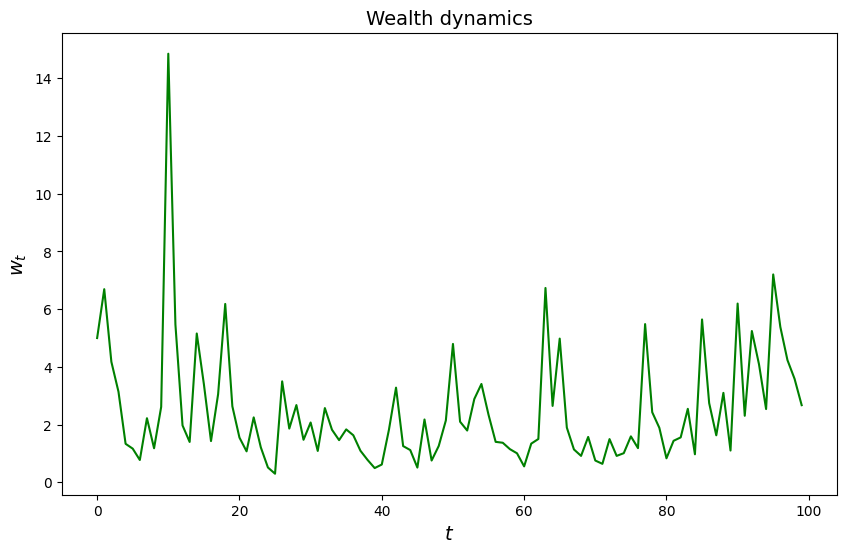

In [13]:
fig, ax = plt.subplots()

T = 100
w = np.empty(T)
w[0] = 5
for t in range(T-1):
    w[t+1] = h(w[t])

ft = 14
ax.plot(w, color = 'green')
ax.set_xlabel('$t$', fontsize = ft)
ax.set_ylabel('$w_{t}$', fontsize = ft)
ax.set_title('Wealth dynamics', fontsize = ft)

plt.show()

Now let’s suppose that we have a large population of households and ***we want to know what median wealth will be***.

In particular, ***we will simulate a large number of households*** and then calculate median wealth for this group.

We are going to simulate 50,000 households by:


1.   Arbitraly setting initial wealth to 1.
2.   Simulating forward in time for 1,000 periods.

Then we’ll calculate median wealth at the end period.

Here’s the ***code***:



In [15]:
@njit
def compute_long_run_median(w0       = 1,              # Initial wealth
                            T        = 1000,            # Periods of time
                            num_reps = 50_000):  # Number of households

    obs = np.empty(num_reps)       # Initialization of observations
    for i in range(num_reps):
        w = w0
        for t in range(T):
            w = h(w)
        obs[i] = w

    return np.median(obs)

Let’s see how fast this runs:

In [16]:
compute_long_run_median()

1.835567571494141

In [17]:
qe.tic()
compute_long_run_median()
timeA = qe.toc()

TOC: Elapsed: 0:00:8.09


To speed this up, we’re going to parallelize it via multithreading.

To do so, we...


*   Add the ***'parallel = True'*** flag.
*   Change ***range to prange***.



In [18]:
from numba import prange

@njit(parallel = True)
def compute_long_run_median_parallel(w0 = 1, T = 1000, num_reps = 50_000):

    obs = np.empty(num_reps)
    for i in prange(num_reps):
        w = w0
        for t in range(T):
            w = h(w)
        obs[i] = w

    return np.median(obs)

Let's look at timing:

In [19]:
compute_long_run_median_parallel()

1.835808037816284

In [20]:
qe.tic()
compute_long_run_median_parallel()
timeB = qe.toc()

TOC: Elapsed: 0:00:4.73


The speed gain can be computed as...

In [21]:
speed_gain1 = timeA / timeB
print(speed_gain1)

1.7092564174149265


# ***3. JAX***

***JAX*** is scientific library within the Python ecosystem that ***provides***:

1.   Data type.
2.   Functions.
3.   Compiler for fast linear algebra operations and automatic differentiation.

Loosely speaking, JAX ***is like NumPy with the addition of***:

1.   Automatic differentiaton.
2.   Automated GPU(Graphic Processing Unit)/TPU (Tensor Processing Unit) support.
  * **GPU's** were originally designed and used for 3D graphics to speed up things, but over time, their parallel computing ability made them an extremely popular choice for use in AI.
  * **TPU's** are application-specific integrated circuits (ASIC) designed specifically to handle the computational demands of machine learning and accelerate AI calculations and algorithms. They do not have the memory access problem that slows down GPUs and CPUs.
3.   A just-in-time compiler.

JAX is often used for machine learning and AI, since it can scale to big data operations on GPUs and automatically differentiate loss functions for gradient decent.

However, ***JAX is sufficiently low-level that it can be used for many purposes***.



## ***3.1. JAX as Numpy replacement***

One way to use JAX is as a plug-in NumPy replacement. Let's look at the similarities and differences.

### ***Similarities***

The following import is standard, replacing import numpy as np:

In [22]:
import jax
import jax.numpy as jnp

Now we can use jnp in place of np for the usual array operations:

In [23]:
a = jnp.asarray((1.0, 2.0, 3.0))
print(a)

[1. 2. 3.]


In [24]:
# For example...
print('The sum of the elements in the array "a" is:',jnp.sum(a))
print('The average of the elements in the array "a" is:',jnp.mean(a))

The sum of the elements in the array "a" is: 6.0
The average of the elements in the array "a" is: 2.0


However, the array "a" is not a NumPy array:

In [25]:
type(a)

jaxlib.xla_extension.ArrayImpl

Operations on higher dimensional arrays is also similar to NumPy:

In [26]:
A = jnp.ones((2,2))
B = jnp.identity(2)
A @ B

Array([[1., 1.],
       [1., 1.]], dtype=float32)

In [27]:
from jax.numpy import linalg

In [28]:
# Solves the linear system Bx=A
linalg.solve(B, A)

Array([[1., 1.],
       [1., 1.]], dtype=float32)

In [29]:
# Compute eigenvalues and eigenvectors
linalg.eigh(B)

(Array([1., 1.], dtype=float32),
 Array([[1., 0.],
        [0., 1.]], dtype=float32))

### ***Differences***

One difference between NumPy and JAX is that, when running on a GPU, ***JAX uses 32 bit floats by default***. This is standard for GPU computing and can lead to significant speed gains with small loss of precision.

However, for some calculations precision matters. ***In these cases 64 bit floats can be enforced via the command***.

In [30]:
jax.config.update("jax_enable_x64", True)

Let's check if this works...

In [31]:
jnp.ones(3)

Array([1., 1., 1.], dtype=float64)

As a NumPy replacement, a more significant difference is that ***arrays are treated as immutable***. For example, with NumPy we can write...

In [32]:
a = np.linspace(0, 1, 3)
print(a)

[0.  0.5 1. ]


In [33]:
# And then mutate the data in memory.
a[0] = 1
print(a)

[1.  0.5 1. ]


In JAX, this fails...

In [34]:
b = jnp.linspace(0, 1, 3)
print(b)

[0.  0.5 1. ]


In [35]:
b[0] = 1
print(b)

TypeError: ignored

In line with immutability, JAX does not support inplace operations.

In [36]:
c = np.array((2, 1))
c.sort()
print(c)

[1 2]


In [37]:
d = jnp.array((2, 1))
d.sort()
print(d)

[2 1]


The ***designers of JAX chose to make arrays immutable because JAX uses a functional programming style***.


## ***3.2. Random Numbers in JAX***

Random numbers are also a bit different in JAX, relative to NumPy. Typically, in JAX, ***the state of the random number generator needs to be controlled*** explicitly.

In [38]:
import jax.random as random

First we produce a key, which seeds the random number generator.

In [39]:
key = random.PRNGKey(1)    # Initial value of the random seed
print(key)

[0 1]


Now we can use the key to generate some random numbers:

In [40]:
x = random.normal(key, (3, 3))
print(x)

[[-1.35247421 -0.2712502  -0.02920518]
 [ 0.34706456  0.5464053  -1.52325812]
 [ 0.41677264 -0.59710138 -0.5678208 ]]


**'random.normal(key, (3, 3))'** generates a matrix of size 3x3 where each element of the matrix is ​​a random number drawn from a normal distribution with mean zero and variance one.

If we use the same key again, we initialize at the same seed, so the random numbers are the same:

In [41]:
random.normal(key,(3,3))

Array([[-1.35247421, -0.2712502 , -0.02920518],
       [ 0.34706456,  0.5464053 , -1.52325812],
       [ 0.41677264, -0.59710138, -0.5678208 ]], dtype=float64)

To produce a (quasi-) independent draw, best practice is to "split" the existing key:

In [42]:
'''
This code divides a random seed (key) into two new random seeds (subkey and the seed resulting from the division).
These additional seeds can be used to generate sequences of pseudorandom numbers independent of each other.
'''

key, subkey = random.split(key)

In [43]:
random.normal(key, (3, 3))

Array([[ 1.85374374, -0.37683949, -0.61276867],
       [-1.91829718,  0.27219409,  0.54922246],
       [ 0.40451442, -0.58726839, -0.63967753]], dtype=float64)

In [44]:
random.normal(subkey, (3, 3))

Array([[-0.4300635 ,  0.22778552,  0.57241269],
       [-0.15969178,  0.46719192,  0.21165091],
       [ 0.84118631,  1.18671326, -0.16607783]], dtype=float64)

The function below produces k (quasi-) independent random n x n matrices using this procedure.

In [45]:
'''
The function gen_random_matrices(key, n, k) generates a list of k random matrices of size n x n.
'''

def gen_random_matrices(key, n, k):
    matrices = []
    for _ in range(k):
        key, subkey = random.split(key)
        matrices.append(random.uniform(subkey, (n, n)))
    return matrices

In [46]:
matrices = gen_random_matrices(key, 2, 2)
for A in matrices:
    print(A)

[[0.97440813 0.3838544 ]
 [0.9790686  0.99981046]]
[[0.3473302  0.17157842]
 [0.89346686 0.01403153]]


## ***3.3. JIT compilation***

The JAX JIT compiler accelerates logic within functions by fusing linear algebra operations into a single, highly optimized kernel that the host can launch on the GPU / TPU (or CPU if no accelerator is detected).

Consider the following pure Python function.

In [47]:
def f(x, p = 1000):
    return sum((k*x for k in range(p)))

Let's build an array to call the function on.

In [48]:
n = 500_000
x = jnp.ones(n)

In [49]:
f(x)

Array([499500., 499500., 499500., ..., 499500., 499500., 499500.],      dtype=float64)

In [50]:
qe.tic()
f(x)
time_x = qe.toc()

TOC: Elapsed: 0:00:1.04


This code is not particularly fast.

If we JIT-compile the function with JAX, then the operations are fused and no intermediate arrays are created.

In [51]:
f_jit = jax.jit(f)

such that...

In [52]:
f_jit(x)

Array([499500., 499500., 499500., ..., 499500., 499500., 499500.],      dtype=float64)

In [54]:
qe.tic()
f_jit(x)
time_y = qe.toc()

TOC: Elapsed: 0:00:0.09


The speed gain can be computed as...

In [55]:
speed_gain2 = time_x / time_y
print(speed_gain2)

10.545248144304827


## ***3.4. Functional Programming***

JAX assumes a functional programming style.

The major implication is that JAX functions should be pure:

*   No dependence on global variables.
*   No side effects.

"A pure function will always return the same result if invoked with the same inputs."

JAX will not usually throw errors when compiling impure functions but execution becomes unpredictable.

Here's an illustration of this fact, using global variables:



In [56]:
a = 1  # global

@jax.jit
def f(x):
    return a + x


In [57]:
x = jnp.ones(2)
print(x)

[1. 1.]


In [58]:
f(x)

Array([2., 2.], dtype=float64)

In the code above, the global value a=1 is fused into the jitted function.

Even if we change a, the output of f will not be affected --- as long as the same compiled version is called.

In [59]:
a = 42
f(x)

Array([2., 2.], dtype=float64)

Changing the dimension of the input triggers a fresh compilation of the function, at which time the change in the value of a takes effect:

In [60]:
x = np.ones(3)
f(x)

Array([43., 43., 43.], dtype=float64)

## ***3.5. Gradients***


JAX can use automatic differentiation to compute gradients.

This can be extremely useful in optimization, root finding and other applications.

Here's a very simple illustration, involving the function

In [61]:
def f(x):
    return (x**2) / 2

Let's take the derivative:

In [62]:
f_prime = jax.grad(f)


In [63]:
# Grad does not run with integers or bolians
f_prime(10.0)

Array(10., dtype=float64, weak_type=True)

Let's plot the function and derivative, noting that...

$$f'(x)=x$$

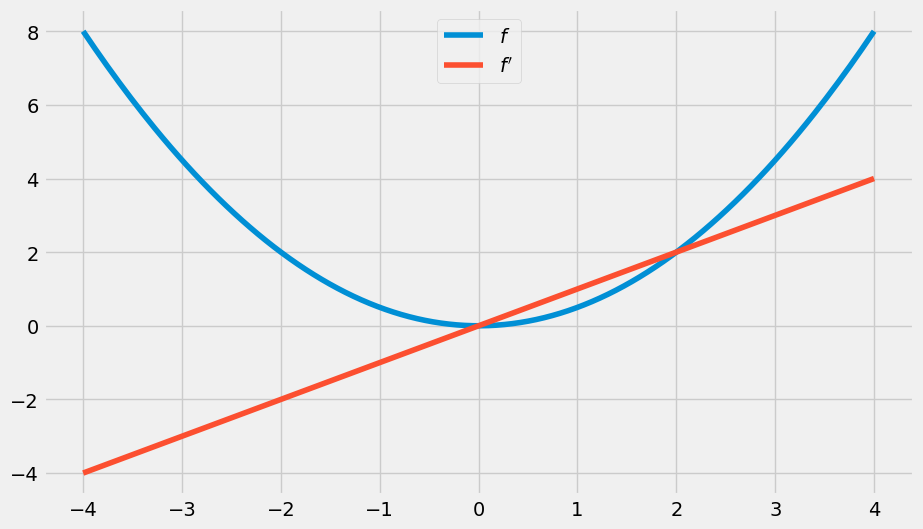

In [64]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
x_grid = jnp.linspace(-4, 4, 200)
ax.plot(x_grid, f(x_grid), label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend(loc='upper center')
plt.show()